## はじめに

本ハンズオンでは機械学習モデルの解釈性をテーマに、どの特徴量がどの程度の影響があるかについて解析する手法をご体感頂きます。実際の本番環境ではデータの量や計算リソースが異なるため活用するツールが異なることが想定されるため、今回のハンズオンのコードの詳細は気にせずに、どういった手順で何をしようとしているのか、特徴量の寄与度を求める流れをご確認下さい。また不明な単語などありましたら、参考文献などでご確認を頂けたらと思います。

今回は[岩波データサイエンス vol.3【特集】因果推論 ― 実世界のデータから因果を読む](https://sites.google.com/site/iwanamidatascience/vol-3/vol3-ingasuiron)で活用されているの[データ](https://github.com/iwanami-datascience/vol3)を活用します。

データの詳細については下記をご参考に下さい。
- [加藤・星野　サポートページ（岩波データサイエンスVol.3 特集 因果推論）](https://sites.google.com/site/iwanamidatascience/vol-3/vol3-ingasuiron/vol3-katouhoshino)
- [データアナリストが活用できる（かもしれない）機械学習](https://speakerdeck.com/nekoumei/detaanarisutogahuo-yong-dekiru-kamosirenai-ji-jie-xue-xi)
- [岩波データサイエンスvol.3のデータで遊ぼう](https://rstudio-pubs-static.s3.amazonaws.com/192092_6a8bac32eac24d7ca3a4791a80e7f3d3.html)


今後のプロトタイピングを実施するに辺り、本ハンズオンを通してご確認頂きたい概念は下記です。
- Tree系アルゴリズムにおける特徴量重要度とその取扱について
- 特徴量重要度を用いた特徴量の目的変数への寄与について
    - 素の特徴量重要度の活用
    - Permutation Importanceの活用
- 任意の特徴量を変化させた時の目的変数の変化について
    - Partianl Dependency Plot(PDP)の活用
- SageMakerでのバッチ推論について

もしご興味がある方は下記についてもご確認頂けると今後の役に立つやもしれません。
- GDBTやXGBoostとは
- 木系アルゴリズムにおける特徴量重要度の計算方法

In [1]:
#!conda install -c conda-forge -y xgboost 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error


import sklearn
import pickle as pkl

# Define IAM role
import boto3
import re

import sagemaker
from sagemaker.session import s3_input
from sagemaker import get_execution_role


from sagemaker.amazon.amazon_estimator import get_image_uri
sess = sagemaker.Session()
role = get_execution_role()

import sagemaker
from sagemaker.predictor import csv_serializer


%matplotlib inline

### データの準備
今回は[岩波データサイエンス vol.3【特集】因果推論 ― 実世界のデータから因果を読む](https://sites.google.com/site/iwanamidatascience/vol-3/vol3-ingasuiron)で活用されている、アプリの利用状況とユーザーの属性などについてまとめた[データ](https://github.com/iwanami-datascience/vol3)を活用します。

既にダミー変数化などは実施されておりこのまま機械学習アルゴリズムの学習に使える形で提供提供されています。
それぞれの特徴量が何を表すかについては[こちらのPDFファイル](https://drive.google.com/file/d/0Bw-J75fYQ33NV19UM3JFLTVJX2s/view)をご参考に頂くと良いです。

In [3]:
url = 'https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'
data = pd.read_csv(url)

# SageMakerの組み込みアルゴリズムへの対応のためデータの並び替え
data = pd.concat([data["gamesecond"], data.drop(["gamedummy", "gamecount", "gamesecond"], axis=1)], axis=1)

# データの簡単な確認
data.head()

,gamesecond,cm_dummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day
0,0,0,0,0,0,1,44.5,1,1,1,...,0,1,0,0,0,0,0,1,0,33.427600
1,0,0,0,1,0,0,34.5,1,1,1,...,0,1,0,0,0,0,0,1,0,31.542862
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,0,0,1,0,0,37.825805
3,0,0,0,1,0,0,44.5,1,1,1,...,0,1,0,0,0,0,0,1,0,36.345911
4,0,0,0,1,0,0,34.5,1,1,1,...,0,1,0,0,0,0,1,0,0,49.344942


## データの分割
データを学習用、検証用、テスト用データへ分割します。学習＆検証用データで構築したモデルに対してテストデータで推論と、その予測値に対してどの特徴量がどの程度寄与しているか、または変化した際に、どの程度影響を及ぼすのかを解析します。

In [4]:
# 学習用データ、検証用データ、テスト用データへ分割
train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])

# 学習用データ、検証用データの保存
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

test_features = test_data.drop(["gamesecond"], axis=1)
test_true = test_data["gamesecond"]
test_features.to_csv("test.csv", header=False, index=False)


# アップロード先を指定
bucket = sess.default_bucket()
prefix = 'sagemaker/feature_importance' 

train_channel = prefix + '/train'
validate_channel = prefix + '/validate'
test_channel = prefix + '/test'


# csvファイルとして保存された学習用データ、検証用データをS3バケット上にアップロード
sagemaker_session = sagemaker.Session()

input_train = sagemaker_session.upload_data(path="train.csv", bucket=bucket, key_prefix=train_channel)
input_validation = sagemaker_session.upload_data(path="validation.csv", bucket=bucket, key_prefix=validate_channel)
input_test = sagemaker_session.upload_data(path="test.csv", bucket=bucket, key_prefix=test_channel)

# アップロードされたデータ
s3_input_train = s3_input(s3_data=input_train, content_type='text/csv')
s3_input_validation = s3_input(s3_data=input_validation, content_type='text/csv')
s3_input_test = s3_input(s3_data=input_test, content_type='text/csv')


# アップロード先のパス
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

##  木系アルゴリズムにおける特徴量重要度とその取扱について
特徴量重要度とは木系アルゴリズムにおいて、学習の過程においてどの特徴量がどの程度予測精度に寄与しているかを計算したものです。

特徴量の寄与度や目的変数への影響を考慮する場合、基本的には一つの特徴量に注目すると思います。しかし特徴量間に相関がある場合、例えば今回の例で言えばinc(年間収入)とjob_dummy_1(正社員、公務員)で0.72の相関があるなどの場合、どちらがどの程度影響を及ぼしているのか必ずしも明確に判断できない場合があります。そのため機械学習モデル構築とその寄与度を把握する前のEDAの段階で相関を見るようにします。下記では、sexとincやageとM3などで相関が少し強めに見られているので注意が必要そうです。

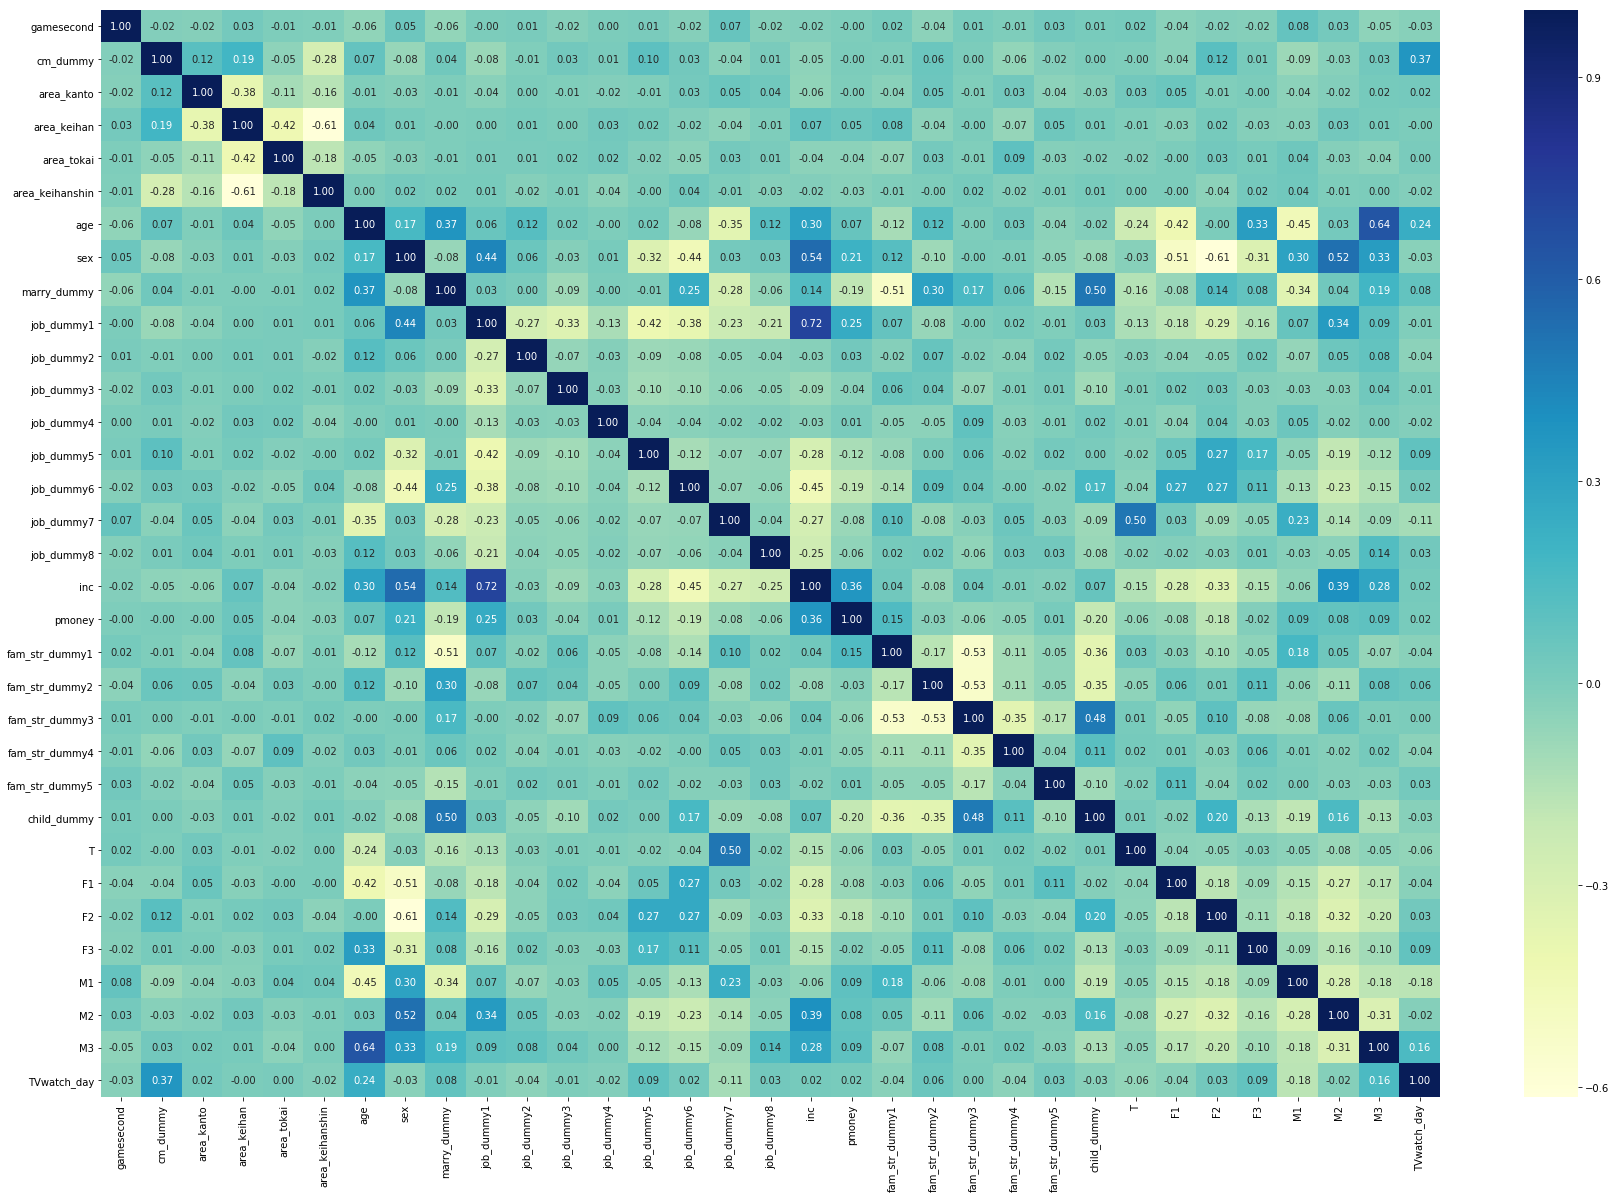

In [5]:
# 相関行列を描く
corr_df = data.corr()
plt.figure(figsize=[30, 20])
sns.heatmap(corr_df, cmap="YlGnBu", annot=True, fmt='.2f')

## 機械学習モデルの構築
特徴量重要度を取得するためにSageMakerのxgboost組み込みアルゴリズムを学習させます。今回は独自には特徴量作成をせずに既にある特徴量を用いてデータを学習させます。

In [7]:
container = get_image_uri(boto3.Session().region_name, 'xgboost')
job_name="xgb-gamesecond-09082030-kazusa"

# どのような学習インスタンスを使うのかの設定
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type="ml.m4.4xlarge",
                                    sagemaker_session=sess,
                                    output_path=s3_output_location)

# XGBoostアルゴリズムのハイパラ設定
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective="reg:linear",
                        num_round=100)

# 学習の開始
xgb.fit({"train": s3_input_train, "validation": s3_input_validation},  job_name=job_name)

2019-09-07 11:29:34 Starting - Starting the training job...
2019-09-07 11:29:39 Starting - Launching requested ML instances......
2019-09-07 11:30:44 Starting - Preparing the instances for training......
2019-09-07 11:32:02 Downloading - Downloading input data
2019-09-07 11:32:02 Training - Downloading the training image..
Arguments: train
[2019-09-07:11:32:16:INFO] Running standalone xgboost training.
[2019-09-07:11:32:16:INFO] File size need to be processed in the node: 0.75mb. Available memory size in the node: 56473.93mb
[2019-09-07:11:32:16:INFO] Determined delimiter of CSV input is ','
[11:32:16] S3DistributionType set as FullyReplicated
[11:32:16] 7000x32 matrix with 224000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-09-07:11:32:16:INFO] Determined delimiter of CSV input is ','
[11:32:16] S3DistributionType set as FullyReplicated
[11:32:16] 2000x32 matrix with 64000 entries loaded from /opt/ml/input/data/validation?format=csv&label_co

## 学習させたモデルから素の特徴量重要度を取得

In [8]:
# 学習させたxgboostモデルのダウンロード
s3 = boto3.client('s3')
s3.download_file(Bucket=bucket, Key= prefix + "/output/" + job_name + "/output/model.tar.gz", Filename = 'model.tar.gz')

In [9]:
# xgboostモデルの解凍
!tar -zxvf model.tar.gz

xgboost-model


[11:32:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<BarContainer object of 10 artists>

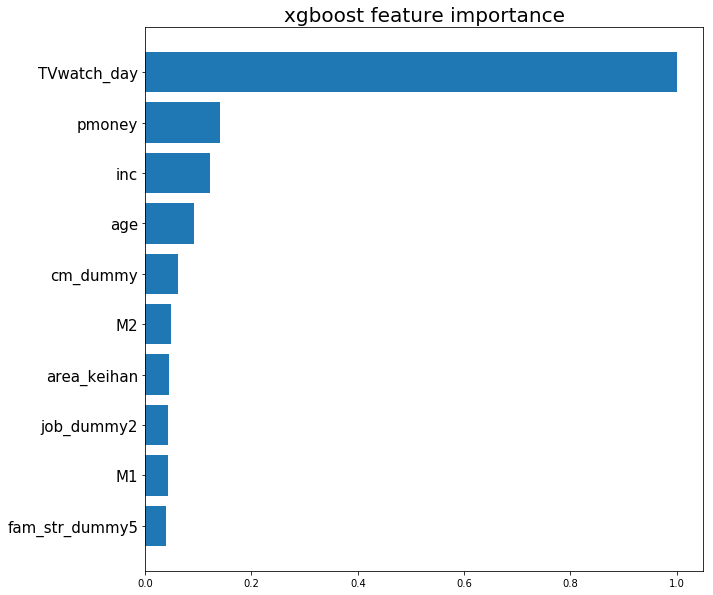

In [10]:
# ダウンロードしてきたxgboostモデルの読み込み
bst = pkl.load(open("xgboost-model", 'rb'))

# 特徴量重要度を読み込むためのデータフレームの準備
dict_varImp = bst.get_score(importance_type = 'weight')
df_ = pd.DataFrame(dict_varImp, index = ['varImp']).transpose().reset_index()
df_.columns = ['feature', 'fscore']

# 上位10個の特徴量重要度を描写
df_['fscore'] = df_['fscore'] / df_['fscore'].max()
df_.sort_values('fscore', ascending = False, inplace = True)
df_ = df_[0:10]
df_.sort_values('fscore', ascending = True, inplace = True)

fscore = df_['fscore']
feature = df_['feature']

mapper = {'f{0}'.format(i): v for i, v in enumerate(data.columns.drop("gamesecond"))}
mapped_feature = [mapper[f] for f in df_["feature"]]

plt.figure(figsize=(10,10))
plt.title('xgboost feature importance', fontsize = 20)
plt.yticks(fontsize=15)
plt.barh(mapped_feature,fscore)

## Permutation importanceの活用
任意の特徴量をランダムに並べ替えると、そのデータは実際の世界で観測されるものと異なるため、推論時にモデルの予測精度が低下します。
予測に重要な特徴量をシャッフルした場合には特に精度の落ち込みが激しくなるはずです。この考え方に基づいた特徴量の目的変数への寄与度の算出方法がPErmutation importanceです。 
手順は下記になります。

- テスト用データを推論し本来の目的変数の値(今回はゲームの使用時間)と予測値のRSME(平均二乗誤差)を計算しベーススコアとします。
- テスト用のデータの任意の特徴量のみをランダムに並び替えます。
- 並び変えたデータを学習済モデルへ並び替えたデータ(Permuted data)で推論します。
- 本来の目的変数の値(今回はゲームの使用時間)と並べ替えられた予測値のRSME(平均二乗誤差)を計算します。
- ベーススコアと並べ変えた場合のスコアを比較して、その特徴量のPermutated importanceとします。

先程と同様にimportanceという単語が使われていますが重要度に使っている指標が異なります。

### ベーススコアの計算

In [ ]:
# バッチ変換用のインスタンスを設定
xgb_transformer = xgb.transformer(instance_count=1,
                                  instance_type='ml.m4.4xlarge',
                                  strategy='MultiRecord',
                                  assemble_with='Line',
                                  output_path=s3_output_location)

# バッチ変換用ジョブを設定
xgb_transformer.transform(data=input_test, content_type='text/csv', split_type='Line')

# バッチ変換の開始
xgb_transformer.wait()

# 手元でベーススコアを計算するためバッチ変換データのダウンロード
s3 = boto3.client('s3')
s3.download_file(Bucket=bucket, Key= prefix + "/output/" + "test.csv.out", Filename = "test.csv.out")

# テストデータでの本来の値と予測値を読み込み
test_true = test_data["gamesecond"]
test_predict = pd.read_csv("test.csv.out", names=["predict"])

# 本来の値と予測値の平均二乗誤差を計算
base_score = mean_squared_error(test_true, test_predict)
print("ベーススコアは {} です".format(base_score))

.............

### Permutation importanceの計算
今回は例として「TVWatch_day」の特徴量をデータごとにシャッフルしてPermutation importanceを計算してみます。

In [ ]:
# 特徴量のシャッフル
test_permuted = test_features.copy()
test_permuted["TVwatch_day"] = np.random.permutation(test_permuted["TVwatch_day"])
test_permuted.to_csv("test_permuted.csv", header=False, index=False)

# 変換後データのアップロード先を指定
bucket = sess.default_bucket()
prefix = 'sagemaker/feature_importance' 
permuted_channel = prefix + '/test_permuted'


# csvファイルとして保存された学習用データ、検証用データをS3バケット上にアップロード
sagemaker_session = sagemaker.Session()
input_permuted = sagemaker_session.upload_data(path="test_permuted.csv", bucket=bucket, key_prefix=permuted_channel)

# アップロードされたデータ
s3_input_test = s3_input(s3_data=input_permuted, content_type='text/csv')

# アップロード先のパス
s3_purmuted_data = 's3://{}/{}'.format(bucket, permuted_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

# バッチ変換用のインスタンスを設定
xgb_transformer = xgb.transformer(instance_count=1,
                                  instance_type='ml.m4.xlarge',
                                  strategy='MultiRecord',
                                  assemble_with='Line',
                                  output_path=s3_output_location)

# バッチ変換用ジョブを設定
xgb_transformer.transform(data=input_permuted, content_type='text/csv', split_type='Line')

# バッチ変換の開始
xgb_transformer.wait()


# 手元でベーススコアを計算するためバッチ変換データのダウンロード
s3 = boto3.client('s3')
s3.download_file(Bucket=bucket, Key= prefix + "/output/" + "test_permuted.csv.out", Filename = "test_permuted.csv.out")


# シャッフルしたデータでの予測値を読み込み
test_permuted_predict = pd.read_csv("test_permuted.csv.out", names=["predict"])

# 本来の値と予測値の平均二乗誤差を計算
permuted_score = mean_squared_error(test_true, test_permuted_predict)
permuted_importance = permuted_score - base_score

print("シャッフル時のスコアは {} です".format(permuted_score))
print("Permuted Importanceは {} です".format(permuted_importance ))

### すべての特徴量に対してPermutation importanceを計算
他の特徴量についてもPermutation importanceを計算したい場合には下記を実行して下さい。計算に時間がかかるので本ハンズオンの時間の中では実施致しません。
実行したい場合には下記のセルを「Raw」から「Code」へ変更し実行して下さい。

In [13]:
def permuted(df):
    """カラム名と、その特定のカラムをシャッフルしたデータフレームを返す"""
    for column_name in df.columns:
        permuted_df = df.copy()
        permuted_df[column_name] = np.random.permutation(permuted_df[column_name])
        yield column_name, permuted_df
        
        
# 特定のカラムをシャッフルした状態で推論したときのスコアを計算する
permuted_test_features_gen = permuted(test_features)
permutation_scores = []
for column_name, permuted_X_test in permuted_test_features_gen:
    print("{} のPermuted Importanceをはかっています".format(column_name))
    permuted_X_test.to_csv("test_permuted_{}.csv".format(column_name), header=False, index=False)

    # アップロード先を指定
    bucket = sess.default_bucket()
    prefix = 'sagemaker/feature_importance' 
    permuted_channel = prefix + '/test_permuted'


    # csvファイルとして保存された学習用データ、検証用データをS3バケット上にアップロード
    sagemaker_session = sagemaker.Session()
    input_permuted = sagemaker_session.upload_data(path="test_permuted_{}.csv".format(column_name), bucket=bucket, key_prefix=permuted_channel)

    # アップロードされたデータ
    s3_input_test = s3_input(s3_data=input_permuted, content_type='text/csv')

    # アップロード先のパス
    s3_purmuted_data = 's3://{}/{}'.format(bucket, permuted_channel)
    s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

    # バッチ変換用のインスタンスを設定
    xgb_transformer = xgb.transformer(instance_count=1,
                                      instance_type='ml.m4.xlarge',
                                      strategy='MultiRecord',
                                      assemble_with='Line',
                                      output_path=s3_output_location)


    # バッチ変換用ジョブを設定
    xgb_transformer.transform(data=input_permuted, content_type='text/csv', split_type='Line')
    
    # バッチ変換の開始
    xgb_transformer.wait()
    
    
    # バッチ変換データのダウンロード
    s3 = boto3.client('s3')
    s3.download_file(Bucket=bucket,
                     Key= prefix + "/output/" + "test_permuted_{}.csv.out".format(column_name),
                     Filename = "test_permuted_{}.csv.out".format(column_name))
    
    




    # シャッフルしたデータでの予測値を読み込み
    test_permuted_predict = pd.read_csv("test_permuted_{}.csv.out".format(column_name), names=["predict"])
    
    # 本来の値と予測値の平均二乗誤差を計算
    permuted_score = mean_squared_error(test_true, test_permuted_predict)
    permuted_importance = permuted_score - base_score
    
    print("{} のシャッフル時のスコアは {} です".format(column_name, permuted_score))
    print("{} のPermuted Importanceは {} です".format(column_name, permuted_importance ))

    permutation_scores.append(permuted_score)
    
df_permutation_scores = pd.Series(permutation_scores, index=test_features.columns) 
df_permutation_scores.to_csv("permutation_scores.csv", header=False, index=True)


plt.figure(figsize=(10,10))
plt.title('xgboost parmutation importance', fontsize = 20)
plt.yticks(fontsize=15)
plt.barh(test_features.columns,df_permutation_scores)

実行した結果を下記になります。

![title](parmutation_importance.png)

## Partial Dependency Plotの活用
Partial Dependency Plotは特徴量の寄与度だけでなく、その特徴量の変化した際にどの程度目的変数が変化するかを確認するために活用されます。
手順は下記になります。
- 検証データのある点を元にして、影響を見たい1つの特徴量だけを変化させたデータセットを作成する
- そのデータに対して学習済モデルで推論をを実施する
- 1つの特徴量が変化するとそれぞれのデータ点の予測はどう変わるのかを計算する
- その平均をプロットする

今回は素の特徴量で一番"TVwatch_day"に対して5個のデータ点で推論することでPartial Dependency Plotを描いていきます。

Target feature TVwatch_day is transformed as 365.805924783


........................................!
Target feature TVwatch_day is transformed as 5280.8453218564


........................................!
Target feature TVwatch_day is transformed as 10195.884718929801


.......................................!
Target feature TVwatch_day is transformed as 15110.924116003202


.......................................!
Target feature TVwatch_day is transformed as 20025.9635130766


........................................!


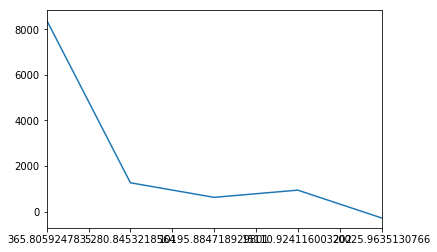

In [87]:
def partial(df, target_column):
    """target featureの値を周辺化したデータフレームを返す"""
    max_value = df[target_column].quantile(0.95)
    min_value = df[target_column].quantile(0.05)
    interval = (max_value - min_value)/5
    
    range_target_column = np.arange(min_value,max_value, interval)
    for v in range_target_column:
        pdp_df = df.copy()
        pdp_df[target_column] = v
        yield v, pdp_df

# 対象となる特徴量を設定      
target_column = "TVwatch_day"

# 対象となる特徴量に対して
pdp_test_features_gen = partial(df=test_features, target_column=target_column)

df_plot = pd.DataFrame()

for pdp_value, pdp_test_features in pdp_test_features_gen:
    # 特定のカラムを特定の値にした状態で推論したときのスコアを計算する
    print("Target feature {} is transformed as {}".format(target_column, pdp_value))
    
    pdp_test_features.to_csv("test_X_{}_{}.csv".format(target_column, pdp_value), header=False, index=False)

    # アップロード先を指定
    bucket = sess.default_bucket()
    prefix = 'sagemaker/feature_importance' 
    pdp_channel = prefix + '/test_pdp'


    # csvファイルとして保存された学習用データ、検証用データをS3バケット上にアップロード
    sagemaker_session = sagemaker.Session()
    input_pdp = sagemaker_session.upload_data(path="test_X_{}_{}.csv".format(target_column, pdp_value), bucket=bucket, key_prefix=pdp_channel)

    # アップロードされたデータ
    s3_input_test = s3_input(s3_data=input_pdp, content_type='text/csv')

    # アップロード先のパス
    s3_pdp_data = 's3://{}/{}'.format(bucket, pdp_channel)
    s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

    # バッチ変換用のインスタンスを設定
    xgb_transformer = xgb.transformer(instance_count=4,
                                      instance_type='ml.m4.16xlarge',
                                      strategy='MultiRecord',
                                      assemble_with='Line',
                                      output_path=s3_output_location)

    # バッチ変換用ジョブの実行
    xgb_transformer.transform(data=input_pdp,
                              # job_name =  "transform_{}_{}".format(target_column, pdp_value),
                              content_type='text/csv',
                              split_type='Line')
    
    # バッチ変換待機
    xgb_transformer.wait()    
    
    # バッチ変換データのダウンロード
    s3 = boto3.client('s3')
    s3.download_file(Bucket=bucket,
                     Key= prefix + "/output/" + "test_X_{}_{}.csv.out".format(target_column, pdp_value),
                     Filename = "test_X_{}_{}.csv.out".format(target_column, pdp_value))
    
    df_tmp =  pd.read_csv("test_X_{}_{}.csv.out".format(target_column, pdp_value), names=[str(pdp_value)])
    df_plot = pd.concat([df_plot, df_tmp], axis=1)
    

# プロットの実行
plt.figure(figsize=(10,10))
plt.title('xgboost partial dependency plot', fontsize = 20)
plt.yticks(fontsize=15)
plt.plot(df_plot.mean().index,df_plot.mean())

## 参考
XGBoostのアルゴリズムについて
- [XGBoost: A Scalable Tree Boosting System(XGBoostの論文)](https://arxiv.org/abs/1603.02754)
- [XGBoost論文を丁寧に解説する](https://qiita.com/triwave33/items/aad60f25485a4595b5c8)

XGBoostを含む木系アルゴリズムの解釈について
- [特徴量重要度にバイアスが生じる状況ご存知ですか？](https://aotamasaki.hatenablog.com/entry/bias_in_feature_importances)
- [Python: 特徴量の重要度を Permutation Importance で計測する](https://blog.amedama.jp/entry/permutation-importance)
- [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
- [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)